In [1]:
!pip install batoid

You should consider upgrading via the '/home/andrew/soft/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import batoid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
telescope = batoid.Optic.fromYaml("LSST_r.yaml")

In [4]:
def pupil(thx, thy, nside=512):
    rays = batoid.RayVector.asGrid(
        optic=telescope, lx=10, theta_x=thx, theta_y=thy,
        nx=nside, wavelength=600e-9
    )
    tf = telescope.traceFull(rays)
    w = np.logical_not(tf['Detector']['out'].vignetted)
    # Project to pupil plane
    p = batoid.Plane()
    p.intersectInPlace(tf['M1']['in'])
    return tf['M1']['in'].x[w], tf['M1']['in'].y[w]

In [5]:
thx,thy=np.deg2rad(0.75),0
nside=512
rays = batoid.RayVector.asGrid(
    optic=telescope, lx=10, theta_x=thx, theta_y=thy,
    nx=nside, wavelength=600e-9)
tf = telescope.traceFull(rays)
w = np.logical_not(tf['Detector']['out'].vignetted)
# Project to pupil plane
p = batoid.Plane()
p.intersectInPlace(tf['M1']['in'])
#return tf['POPT2']['in'].x[w], tf['POPT2']['in'].y[w]

In [6]:
tf.keys()

odict_keys(['M1', 'M2', 'M3', 'L1_entrance', 'L1_exit', 'L2_entrance', 'L2_exit', 'Filter_entrance', 'Filter_exit', 'L3_entrance', 'L3_exit', 'Detector'])

In [7]:
tf.keys()

odict_keys(['M1', 'M2', 'M3', 'L1_entrance', 'L1_exit', 'L2_entrance', 'L2_exit', 'Filter_entrance', 'Filter_exit', 'L3_entrance', 'L3_exit', 'Detector'])

/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


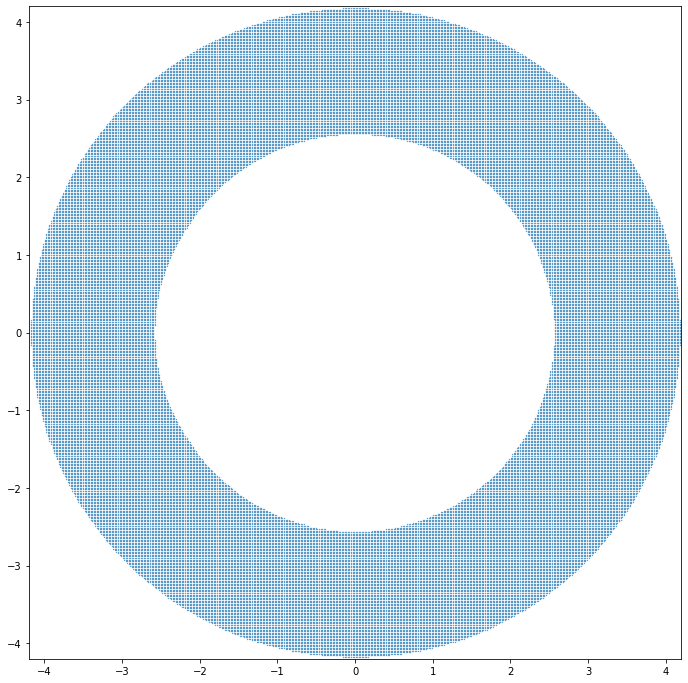

In [8]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.scatter(*pupil(np.deg2rad(0.75),0), s=0.1)
ax.set_xlim(-4.2, 4.2)
ax.set_ylim(-4.2, 4.2)
ax.set_aspect(1)
fig.show()

In [9]:
def spanRange(x, nside=512):
    xmin, xmax = np.min(x), np.max(x)
    xspan = xmax - xmin
    xmin = xmin - 0.8*xspan
    xmax = xmax + 0.8*xspan
    return np.linspace(xmin, xmax, nside)

In [10]:
def pinhole(thx, thy, nside=256):
    # reset skips
    for item in telescope.itemDict:
        telescope[item].skip = False

    # First, need to determine where on the filter to constrain rays.  We'll use the average position of the 
    # pupil beam that would have intersected the filter.
    rays = batoid.RayVector.asGrid(
        optic=telescope, lx=10, theta_x=thx, theta_y=thy,
        nx=nside, wavelength=600e-9
    )
    tf = telescope.traceFull(rays)
    surface = tf['L1_entrance']
    rs = surface['out'].trimVignetted()
    xmean, ymean = np.mean(rs.x), np.mean(rs.y)
    # Now we need to generate a bunch of rays that all pass through the above part of the filter, but over 
    # a range of angles.
    # What is the range of angles for the pupil beam?  
    vx = spanRange(rs.vx, nside=nside)
    vy = spanRange(rs.vy, nside=nside)
    vx, vy = np.meshgrid(vx, vy)
    vz = np.sqrt(1-vx*vx+vy*vy)
    # Now need to make a RayVector with appropriate x,y,vx,vy,...
#     rv = batoid.RayVector([
#         batoid.Ray([xmean, ymean, 0], [vx_, vy_, vz_], 0, 600e-9)
#         for vx_, vy_, vz_ in zip(vx.ravel(), vy.ravel(), vz.ravel())])
    rv = batoid.RayVector.fromArrays(
        xmean*np.ones(nside*nside, dtype=float),
        ymean*np.ones(nside*nside, dtype=float),
        np.zeros(nside*nside, dtype=float),
        vx.ravel(), vy.ravel(), vz.ravel(),
        np.zeros(nside*nside, dtype=float),
        600e-9*np.ones(nside*nside, dtype=float),
        coordSys = surface['out'].coordSys
    )
    # trace forward from filter.  So temporarily skip everything before the filter.
    before_items = ['M1', 'M2', 'M3']
   
    for item in before_items:
        telescope[item].skip = True
    forward_rays = telescope.trace(rv)
    # reset skips
    for item in telescope.itemDict:
        telescope[item].skip = False
    # Now skip everything that happens *after* and including the filter
    after_items = ['L1_entrance', 'L1_exit', 'L2_entrance', 'L2_exit', 
                   'Filter_entrance', 'Filter_exit', 'L3_entrance', 'L3_exit', 'Detector']
    for item in after_items:
        telescope[item].skip = True
    rv = batoid.RayVector.fromArrays(
        rv.x, rv.y, rv.z,
        -rv.vx, -rv.vy, -rv.vz,
        rv.t, rv.wavelength,
        coordSys = rv.coordSys
    )
    reverse_rays = telescope.traceReverse(rv)

    # reset skips
    for item in telescope.itemDict:
        telescope[item].skip = False
        
    w = np.where(np.logical_not(reverse_rays.vignetted))[0]
    return forward_rays.x[w], forward_rays.y[w]

/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


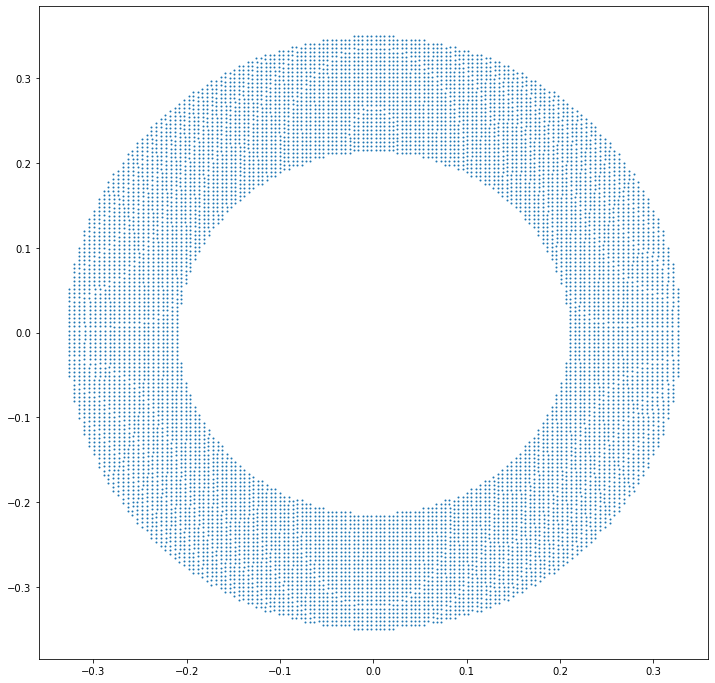

In [11]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.scatter(*pinhole(0,0), s=1)
fig.show()

In [12]:
def plot(thx, thy):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)

    pux, puy = pupil(thx, thy)
    xspan = np.max(pux) - np.min(pux)
    yspan = np.max(puy) - np.min(puy)
    span = max(xspan, yspan)
    pux = (pux - np.mean(pux))/span
    puy = (puy - np.mean(puy))/span
    
    phx, phy = pinhole(thx, thy)
    xspan = np.max(phx) - np.min(phx)
    yspan = np.max(phy) - np.min(phy)
    span = max(xspan, yspan)

    phx = -(phx - np.mean(phx))/span
    phy = -(phy - np.mean(phy))/span

    ax.scatter(pux, puy, s=2, alpha=0.1, c='r', label='pupil')
    ax.scatter(phx, phy, s=2, alpha=0.2, c='b', label='pinhole')
    ax.legend()
    fig.show()

/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


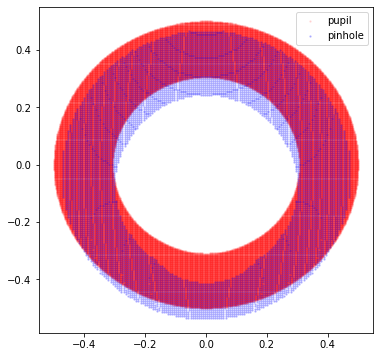

In [13]:
plot(0, np.deg2rad(0.75))

In [14]:
def both(thx, thy):
    pux, puy = pupil(thx, thy)
    xspan = np.max(pux) - np.min(pux)
    yspan = np.max(puy) - np.min(puy)
    span = max(xspan, yspan)
    pux = (pux - np.mean(pux))/span
    puy = (puy - np.mean(puy))/span

    phx, phy = pinhole(thx, thy)
    xspan = np.max(phx) - np.min(phx)
    yspan = np.max(phy) - np.min(phy)
    span = max(xspan, yspan)
    phx = -(phx - np.mean(phx))/span
    phy = -(phy - np.mean(phy))/span

    return pux, puy, phx, phy

/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


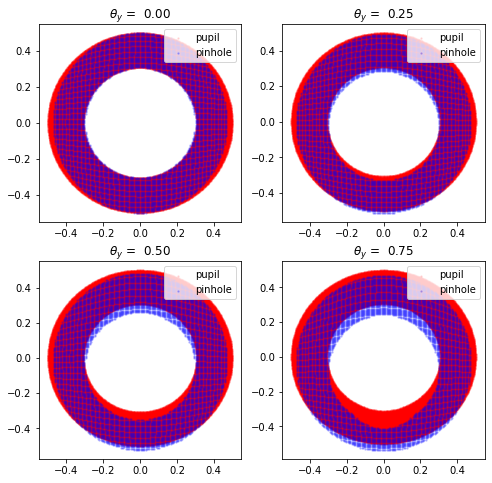

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
for ax, thy in zip(axes.ravel(), [0.0, 0.25, 0.5, 0.75]):
    pux, puy, phx, phy = both(0.0, np.deg2rad(thy))

    ax.scatter(pux, puy, s=2, alpha=0.1, c='r', label='pupil')
    ax.scatter(phx, phy, s=2, alpha=0.2, c='b', label='pinhole')
    ax.set_title(r"$\theta_y$ = {:5.2f}".format(thy))
    ax.legend(loc="upper right")
fig.show()

In [16]:
fiducial_telescope = batoid.Optic.fromYaml("LSST_CCOB_r.yaml")

In [17]:
from mpl_toolkits.mplot3d import Axes3D
from batoid.utils import normalized

In [18]:
%matplotlib widget

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

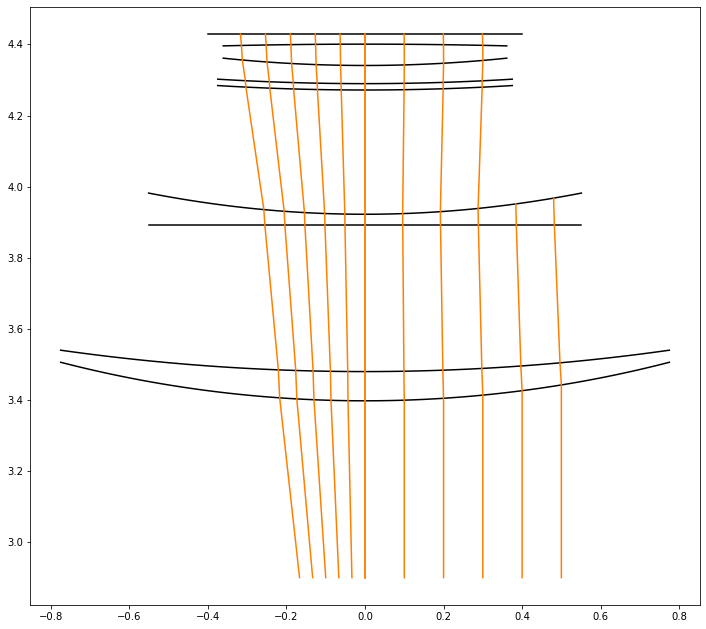

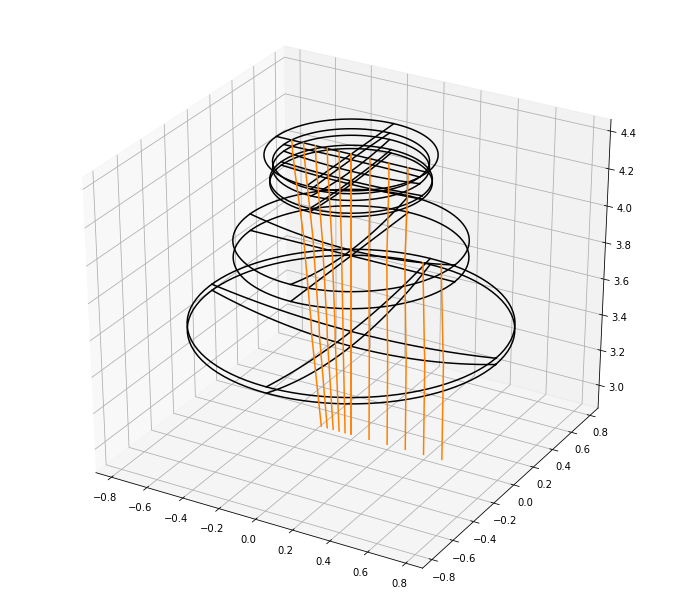

In [19]:
fig1 = plt.figure(figsize=(12, 11))
ax1 = fig1.add_subplot(111)
fiducial_telescope.draw2d(ax1, c='k')
#fiducial_telescope['LSST.LSSTCamera'].draw2d(ax1, c='k')
#ax1.set_xlim(ax1.get_xlim())
#ax1.set_ylim(ax1.get_ylim())

fig2 = plt.figure(figsize=(12, 11))
ax2 = fig2.add_subplot(111, projection='3d')
fiducial_telescope.draw3d(ax2, c='k')
#ax2.set_xlim(ax2.get_xlim())
#ax2.set_ylim(ax2.get_ylim())
#ax2.set_zlim(ax2.get_zlim())

c = '#ff7f00'
rays = []

for dx in range(0, 6, 1):
    p0 = np.array([dx/10., 0, 2.9])
    v = normalized(np.array([0, 0, 1]))/1.000277
    ray = batoid.Ray(p0, v, t=0, wavelength=500e-9)
    p0 = ray.positionAtTime(0)
    rays.append(batoid.Ray(p0, v, t=0, wavelength=500e-9))

for dvx in range(0, 6, 1):
    p0 = np.array([-dvx/30., 0, 2.9])
    v = normalized(np.array([-dvx/50, 0., 1]))/1.000277
    ray = batoid.Ray(p0, v, t=0, wavelength=500e-9)
    p0 = ray.positionAtTime(0)
    rays.append(batoid.Ray(p0, v, t=0, wavelength=500e-9))

traceFull = fiducial_telescope.traceFull(batoid.RayVector(rays))
batoid.drawTrace2d(ax1, traceFull, c=c)
batoid.drawTrace3d(ax2, traceFull, c=c)

In [20]:
rout = traceFull['Detector']['out']
print(rout.coordSys)
for ray in rout:
    print('%.3f\t%.3f'%(ray.x, ray.y))

CoordSys([0,0,4.42942],[[1,0,0],[0,1,0],[0,0,1]])
0.000	0.000
0.100	0.000
0.199	0.000
0.299	0.000
0.399	0.000
0.498	0.000
0.000	0.000
-0.063	0.000
-0.127	0.000
-0.190	0.000
-0.254	0.000
-0.317	0.000


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-0.8525, 0.8525, 2.7, 4.5)

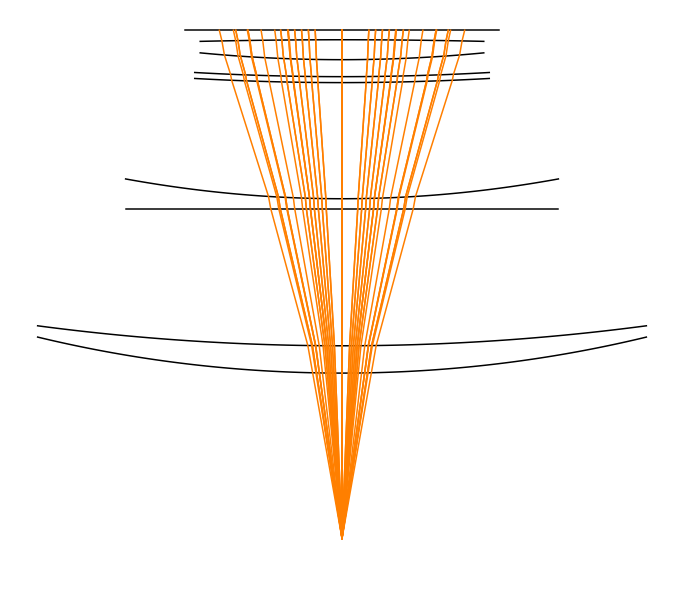

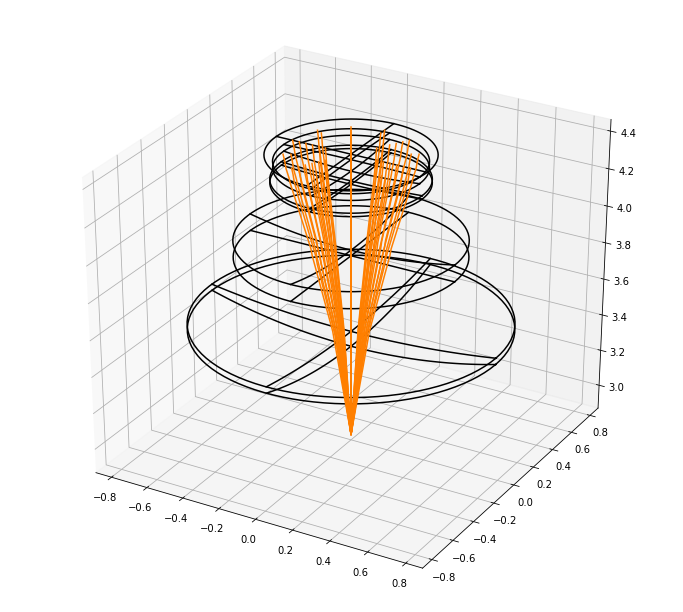

In [21]:
fig1 = plt.figure(figsize=(12, 11))
ax1 = fig1.add_subplot(111)
fiducial_telescope.draw2d(ax1, c='k')
#fiducial_telescope['LSST.LSSTCamera'].draw2d(ax1, c='k')
#ax1.set_xlim(ax1.get_xlim())
#ax1.set_ylim(ax1.get_ylim())
fig2 = plt.figure(figsize=(12, 11))
ax2 = fig2.add_subplot(111, projection='3d')
fiducial_telescope.draw3d(ax2, c='k')
#ax2.set_xlim(ax2.get_xlim())
#ax2.set_ylim(ax2.get_ylim())
#ax2.set_zlim(ax2.get_zlim())

c = '#ff7f00'

# Polar RayVector with similar extent
rays = batoid.RayVector.asPolar(
    optic=fiducial_telescope,
#    backDist=0,
    source = (0.0, 0., 2.9),
    nrad=10,  # number of radii
    naz=15,  # number of azimuths on outermost ring.
    outer=0.015,  # outer radius.  Default inner radius is 0.0
#    dirCos = (0.01, 0., 1),
#    theta_x=np.deg2rad(0.1),
#    theta_y=np.deg2rad(0.0),
#    nrandom=20,
    wavelength=500e-9
)

traceFull = fiducial_telescope.traceFull(rays)
batoid.drawTrace2d(ax1, traceFull, c=c)
batoid.drawTrace3d(ax2, traceFull, c=c)

#ax1.set_title('L')
ax1.set_ylim(2.7,4.5)
ax1.axis('off')